# Physics 760: Computational Physics
## WS 2022/23
### Week 7
#### Pugazharasu Anancia Devaneyan, Rishi Kumar Senthil Kumar

In [56]:
#setup the notebook
%pylab inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math as mth
from scipy import special


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Simulating the Ising model in $d=2$ using the Metropolis-Hasting algorithm

In [57]:
def deltaE(S0, Sn, J, H):
    return 2 * S0 * (H + J * Sn)

In [58]:
def metropolis(sweeps, N, J, h, freq=10):
    spin_list = 2*np.random.randint(2, size=(N,N)) - 1
    final_config = spin_list
    for i in range(sweeps):
        spin_flip_i = np.random.randint(N)
        spin_flip_j = np.random.randint(N)
        
        Sn = spin_list[(spin_flip_i - 1) % N, spin_flip_j] + spin_list[(spin_flip_i + 1) % N, spin_flip_j] + \
             spin_list[spin_flip_i, (spin_flip_j - 1) % N] + spin_list[spin_flip_i, (spin_flip_j + 1) % N]

        change_E = deltaE(spin_list[spin_flip_i,spin_flip_j],Sn,J,h)
        
        rand = np.random.random()
        
        if rand<min(1,np.exp(-1*(change_E))) :
            #flip the spin
            spin_list[spin_flip_i,spin_flip_j]*=-1
        else:
            pass
    
    return spin_list

## Swedensen-Wang

In [59]:
def back_track(L, x, y, bonds, not_visited, cluster, spin_list, sign):
    if not_visited[x, y]:
        not_visited[x, y] = False
        cluster.append([x, y])
        spin_list[x, y] = spin_list[x, y] * sign
                
        if bonds[0][x][y] == np.inf:
            n_x = x
            n_y = (y + 1)%L
            cluster, spin_list = back_track(L, n_x, n_y, bonds, not_visited, cluster, spin_list, sign)
            
        if bonds[0][x][(y - 1)%L] == np.inf:
            n_x = x
            n_y = (y - 1)%L
            cluster, spin_list = back_track(L, n_x, n_y, bonds, not_visited, cluster, spin_list, sign)
            
        if bonds[1][x][y] == np.inf:
            n_x = (x + 1)%L
            n_y = y
            cluster, spin_list = back_track(L, n_x, n_y, bonds, not_visited, cluster, spin_list, sign)
            
        if bonds[1][(x - 1)%L][y] == np.inf:
            n_x = (x - 1)%L
            n_y = y
            cluster, spin_list = back_track(L, n_x, n_y, bonds, not_visited, cluster, spin_list, sign)
            
    return cluster, spin_list

In [60]:
def perc(J,L,spin_list):
    bonds = np.zeros((2, L, L,),dtype=float)
    perc_prob = np.minimum(1, np.exp(-2*J))
    
    delta_spin_hor = np.abs(spin_list+np.roll(spin_list,-1,axis=1))/2 
    nz_delta_spin_hor = np.asarray(np.nonzero(delta_spin_hor)) 

    delta_spin_ver = np.abs(spin_list+np.roll(spin_list,-1,axis=0))/2 
    nz_delta_spin_ver = np.asarray(np.nonzero(delta_spin_ver)) 

    for i in range(np.shape(nz_delta_spin_hor)[1]):
        if np.random.binomial(1, perc_prob) == 1:
            bonds[0, nz_delta_spin_hor[0,i], nz_delta_spin_hor[1,i]] = 0
        else:
            bonds[0, nz_delta_spin_hor[0,i], nz_delta_spin_hor[1,i]] = np.inf

    for j in range(np.shape(nz_delta_spin_ver)[1]):
        if np.random.binomial(1, perc_prob) == 1:
            bonds[1, nz_delta_spin_ver[0,j], nz_delta_spin_ver[1,j]] = 0
        else:
            bonds[1, nz_delta_spin_ver[0,j], nz_delta_spin_ver[1,j]] = np.inf
    
    return bonds

In [61]:
def SW_algorithm(J,L,spin_list):
    islands = []
    clusters = []
    not_visited = np.ones((L, L), dtype= bool)
    
    grid_spins = spin_list
    
    bonds = perc(J,L, grid_spins)
    
    for i in range(L):
        cluster = []
        flip_cluster = 2*np.random.randint(2) - 1 
        spin_site_x = spin_list[0][i]
        spin_site_y = spin_list[1][i]
        cluster, grid_spins = back_track(L,spin_site_x, spin_site_y, bonds, not_visited, cluster, grid_spins, flip_cluster)

        if cluster != []:
            islands.append(cluster)
            clusters.append(flip_cluster)                   
            
    return islands, grid_spins, clusters

## Observables

In [71]:
def numerical_mag(lattice,N):
    mag = np.abs(np.sum(lattice)/(N*N))
    return mag

In [63]:
def energy_exact(J):
    exact_energy = (-J*(1/np.tanh(2*J)))*(1 + (2/np.pi)*((2*(np.tanh(2*J)**2)-1)*(sp.special.ellipkm1(4*((1/np.cosh(2*J))**2)*(np.tanh(2*J)**2)))))
    return exact_energy

In [64]:
def exact_abs_mag(lattice,J,N):
    absolute_exact_mag = (1- (1/(np.sinh(2*J)**4)))**(1/8)
    return absolute_exact_mag

## Plotting

C:\Users\pugaz\AppData\Local\Temp\ipykernel_11500\95036120.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  absolute_exact_mag = (1- (1/(np.sinh(2*J)**4)))**(1/8)
C:\Users\pugaz\AppData\Local\Temp\ipykernel_11500\95036120.py:2: RuntimeWarning: invalid value encountered in double_scalars
  absolute_exact_mag = (1- (1/(np.sinh(2*J)**4)))**(1/8)


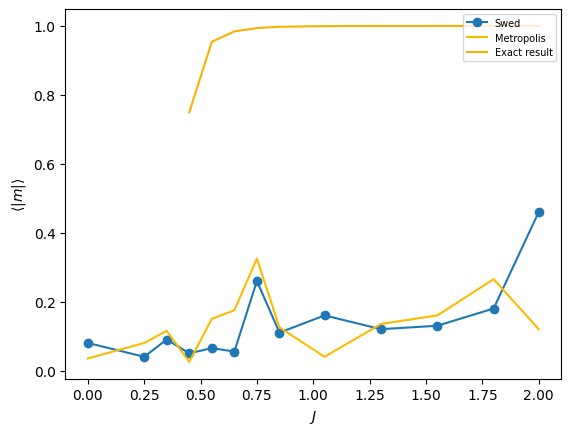

In [76]:
J_list = [0.0,0.25,0.35,0.45,0.55,0.65,0.75,0.85,1.05,1.30,1.55,1.8,2.0]

output = []
metro_output = []
exact_output = []
for j in J_list:
    spin_list = 2*np.random.randint(2, size=(20,20)) - 1
    clusters = SW_algorithm(j,20,spin_list)
    spins = metropolis(1000, 20, j, 0, freq=10)
    exact_output.append(exact_abs_mag(spin_list,j,20))
    output.append(numerical_mag(clusters[1],20))
    metro_output.append(numerical_mag(spins,20))

plt.plot(J_list,output,'o-',label='Swed')
plt.plot(J_list, metro_output, color ='#fbbb00', label='Metropolis')
plt.plot(J_list, exact_output, color ='#fbb000', label='Exact result')

plt.xlabel('$J$')
plt.ylabel('$\\langle  |m| \\rangle$')
plt.legend(loc='upper right',prop={'size': 7})
plt.savefig('Plots/m_v_j.png')